In [1]:
from pde import *
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import json

This function lets me match the parameters to output in case I want to go back to a previous state.

In [2]:
def save_params(params, dir):
    with open(dir, "w") as file:
        json.dump(params, file)

This is the class and code I am using to generate the model.

In [ ]:
# https://py-pde.readthedocs.io/en/latest/examples_gallery/pde_coupled.html#sphx-glr-examples-gallery-pde-coupled-py

class FitzhughNagumoPDE(PDEBase):
    """FitzHugh–Nagumo model with diffusive coupling"""

    def __init__(
        self,
        stimulus=0.5,
        τ=10,
        a=0,
        b=0,
        D=1,
        w_h=1,
        w_l=0.5,
        bc="auto_periodic_neumann"
    ):
        self.bc = bc
        self.stimulus = stimulus
        self.τ = τ
        self.a = a
        self.b = b
        self.D = D
        self.w_h = w_h
        self.w_l = w_l

    def evolution_rate(self, state, t=0):
        v, w = state  # membrane potential and recovery variable

        v_t = self.D * v.laplace(bc=self.bc) + self.stimulus + (v - v**3 / 3 - w)# * self.τ
        w_t = (v + self.a - self.b * w) / self.τ * ((self.w_h - self.w_l) / (1 + np.exp(-4 * v)) + self.w_l)

        return FieldCollection([v_t, w_t])

def run_FN1():
    # grid = UnitGrid([32, 32])
    grid = CartesianGrid([[-1, 1], [-1, 1]], [40, 40])
    # state = FieldCollection.scalar_random_uniform(2, grid)
    dx = 1/40
    origin = np.array([20, 20])
    data = np.zeros(shape=(2, 40, 40))
    # data[:, 9, 10] = data[:, 10, 9] = data[:, 11, 10] = data[:, 10, 11] = -0.5
    # data[:, 10, 10] = -1
    data[0, 20, 20] = -1.0367
    data[1, 20, 20] = -0.6656

    # Cos init
    # for i in range(40):
    #     for j in range(40):
    #         pos = np.array([i, j]) - origin
    #         pos = pos.astype(np.float64)
    #         pos *= dx
    #         r = np.sqrt(np.dot(pos, pos))
    #         data[0, i, j] = np.cos(r * 10 * np.pi)
    #         data[1, i, j] = np.cos(r * 10 * np.pi)


    v_state = ScalarField(grid, data[0])
    w_state = ScalarField(grid, data[1])
    state = FieldCollection((v_state, w_state))

    # Good waves #1
    # params = {
    #     "a": 0.7,
    #     "b": 0.5,
    #     "τ": 1/0.85,
    #     "stimulus": 1,
    #     "D": 0.0001,
    #     "w_h": 0.6,
    #     "w_l": 0.4,
    # }

    
    # N = 128
    # T = 1000
    # t0 = 0
    # dt = 0.1
    # s = 0.02 # 0.02 # 0.10
    # D = 1.0
    # a = 0.5
    # b = 0.7
    # c = 0.3
    # I = 1.0 # 1.0 # 0.5 # 1.0
    # Other params
    params = {
        "stimulus": 0,
        "a": 0.5,
        "b": 0.7,
        "τ": 1/0.3,
        "w_h": 1,
        "w_l": 1,
        "D": 1
    }

    # Chick
    # params = {
    #     "a": 0.7,
    #     "b": 0.5,
    #     "τ": 1/0.44,
    #     "stimulus": 0,
    #     "w_h": 0.6,
    #     "w_l": 0.4,
    #     "D": 0.001
    # }
    memory_storage = MemoryStorage()
    eq = FitzhughNagumoPDE(**params)
    result = eq.solve(state, t_range=100, dt=0.01, tracker=[memory_storage.tracker(0.1)])
    result.plot()
    plot_kymographs(memory_storage)
    data = memory_storage.data
    data = np.array(data)
    vs = data[:, 0, :]
    ws = data[:, 1, :]

    save_images = False
    if save_images:
        for a in tqdm(range(0, 1000, 20)):
            fig = plt.figure()
            fig.set_size_inches((8, 3))
            axs = fig.subplots(1, 2, squeeze=False)
            axes_image = axs[0, 0].imshow(vs[a], vmin=vmin, vmax=vmax)
            plt.colorbar(axes_image, ax=axs[0, 0])
            axes_image = axs[0, 1].imshow(ws[a], vmin=vmin, vmax=vmax)
            plt.colorbar(axes_image, ax=axs[0, 1])
            plt.savefig(f"./fn_images/{a}.png")
            plt.close(fig)
    print("Done!")
run_FN1()


In [ ]:

from typing import Callable, Tuple
from pde.tools.numba import jit

class ExplicitTModSolver(ExplicitSolver):
    def _make_fixed_euler_stepper(
        self, state: FieldBase, dt: float
    ) -> Callable[[np.ndarray, float, int], Tuple[float, float]]:
        """make a simple Euler stepper with fixed time step

        Args:
            state (:class:`~pde.fields.base.FieldBase`):
                An example for the state from which the grid and other information can
                be extracted
            dt (float):
                Time step of the explicit stepping.

        Returns:
            Function that can be called to advance the `state` from time `t_start` to
            time `t_end`. The function call signature is `(state: numpy.ndarray,
            t_start: float, steps: int)`
        """
        # obtain post-step action function
        modify_after_step = jit(self.pde.make_modify_after_step(state))

        if self.pde.is_sde:
            # handle stochastic version of the pde
            rhs_sde = self._make_sde_rhs(state, backend=self.backend)

            def stepper(
                state_data: np.ndarray, t_start: float, steps: int
            ) -> Tuple[float, float]:
                """compiled inner loop for speed"""
                modifications = 0.0
                for i in range(steps):
                    # calculate the right hand side
                    t = t_start + i * dt
                    evolution_rate, noise_realization = rhs_sde(state_data, t)
                    state_data += dt * evolution_rate
                    if noise_realization is not None:
                        state_data += np.sqrt(dt) * noise_realization
                    modifications += modify_after_step(state_data, t)

                return t + dt, modifications

            self.info["stochastic"] = True
            self._logger.info(
                f"Initialized explicit Euler-Maruyama stepper with dt=%g", dt
            )

        else:
            # handle deterministic version of the pde
            rhs_pde = self._make_pde_rhs(state, backend=self.backend)

            def stepper(
                state_data: np.ndarray, t_start: float, steps: int
            ) -> Tuple[float, float]:
                """compiled inner loop for speed"""
                modifications = 0
                for i in range(steps):
                    # calculate the right hand side
                    t = t_start + i * dt
                    state_data += dt * rhs_pde(state_data, t)
                    modifications += modify_after_step(state_data)

                return t + dt, modifications

            self.info["stochastic"] = False
            self.info["adaptive"] = False
            self._logger.info(f"Initialized explicit Euler stepper with dt=%g", dt)

        return stepper


In [24]:
class FHN(PDEBase):
    def __init__(self, N, T, dt, D, a, b, c, I0, stim, bc="auto_periodic_neumann"):
        self.N = N
        self.T = T
        self.dt = dt
        self.D = D
        self.a = a
        self.b = b
        self.c = c
        self.I = I0
        self.bc = bc
        self.I = np.zeros((T,N,N))
        for st in stim:
            t_on, t_off = st[0]
            x0, x1 = st[1]
            y0, y1 = st[2]
            self.I[t_on:t_off, x0:x1, y0:y1] = I0

    # def make_modify_after_step(self, state: FieldBase):
    #     def modify_after_step(state_data: np.ndarray, t=None) -> float:
    #         """no-op function"""
    #         return 0

    #     return modify_after_step

    def evolution_rate(self, state, t=0):
        v, w = state

        dv = (v - v ** 3 / 3 - w + self.I[int(t / self.dt), :, :]) / self.c + self.D * v.laplace(bc=self.bc)
        dw = self.c * (v - self.a*w + self.b)
        return FieldCollection([dv, dw])
        

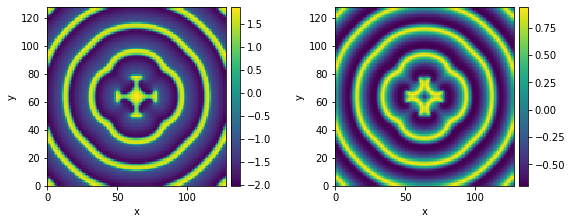

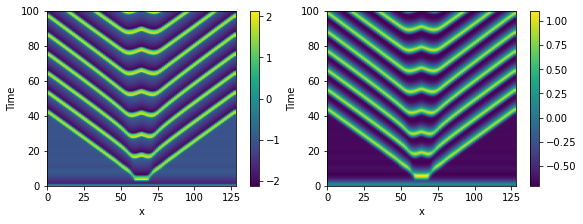

In [25]:
def run_FN2():
    T = 1000
    t0 = 0
    dt = 0.1
    s = 0.02 # 0.02 # 0.10

    N = 128
    D = 1.0
    a = 0.5
    b = 0.7
    c = 0.3
    I = 1.0 # 1.0 # 0.5 # 1.0
    stim = [ [[25, 40], [N // 2 - 5, N // 2 + 5], [N // 2 - 5, N // 2 + 5]] ]

    params = {
        "N": N,
        "T": T,
        "dt": dt,
        "D": D,
        "a": a,
        "b": b,
        "c": c,
        "I0": I,
        # stim protocol, array of elements [[t0,t1], [x0,x1], [y0,y1]]
        "stim": stim
    }
    eq = FHN(**params)

    def get_initial_state():
        grid = UnitGrid((N, N))
        data_v = np.zeros((N, N))
        data_w = np.zeros((N, N))
        # data_v[N // 2, N // 2] = I
        v0 = ScalarField(grid, data_v)
        w0 = ScalarField(grid, data_w)
        return grid, FieldCollection((v0, w0))

    grid, vw0 = get_initial_state()
    memory_storage = MemoryStorage()
    result = eq.solve(vw0, t_range=T * dt, dt=dt, tracker=[memory_storage.tracker(dt)])#, method=ExplicitTModSolver, adaptive=False)

    # Plotting
    result.plot()
    plot_kymographs(memory_storage)
    data = memory_storage.data
    data = np.array(data)
    vs = data[:, 0, :]
    ws = data[:, 1, :]
    return grid, params, memory_storage, data, vs, ws
grid, params, memory_storage, data, vs, ws = run_FN2()


## Pandas visualization

In [ ]:
import pandas as pd
v_state = ScalarField(grid, data[0, 0])
w_state = ScalarField(grid, data[1, 0])
D = 1
bc = "auto_periodic_neumann"
τ = 1/0.44
stimulus = 0
v_t = D * v_state.laplace(bc=bc)# + τ * (v_state - v_state**3 / 3 - w_state) + stimulus
v_t.data
df = pd.DataFrame(v_t.data)
df.style


## Root plot

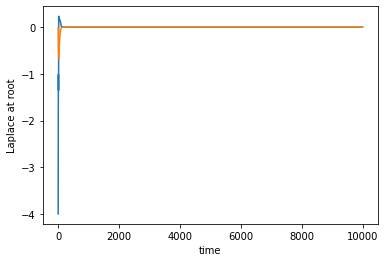

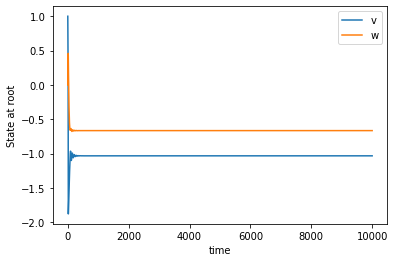

In [7]:
# rootx, rooty = 20, 20
rootx, rooty = 64, 64

top_v = vs[:, rootx, rooty]
top_w = ws[:, rootx, rooty]
bc = "auto_periodic_neumann"
lap_v = np.empty(len(top_v))
lap_w = np.empty(len(top_w))
for a in range(len(top_v)):
    lap = ScalarField(grid, vs[a]).laplace(bc=bc)
    lap_v[a] = lap.data[rootx, rooty]
    lap = ScalarField(grid, ws[a]).laplace(bc=bc)
    lap_w[a] = lap.data[rootx, rooty]

plt.plot(lap_v)
plt.plot(lap_w)
plt.xlabel("time")
plt.ylabel("Laplace at root")
plt.show()
plt.plot(top_v, label="v")
plt.plot(top_w, label="w")
plt.legend()
plt.xlabel("time")
plt.ylabel("State at root")
plt.show()

In [ ]:
plt.plot(top_v[0:20])
plt.plot(lap_v[0:20])

In [8]:
vmin = None
vmax = None

In [11]:
vmin = -2
vmax = 2

## Animation

In [26]:

dir = "./fn_images/fixed_z_fhn2d/"
os.makedirs(dir, exist_ok=True)
save_params(params, f"{dir}/params.json")
for a in tqdm(range(0, 1000, 1)):
    fig = plt.figure()
    fig.set_size_inches((8, 3))
    axs = fig.subplots(1, 2, squeeze=False)
    axes_image = axs[0, 0].imshow(vs[a], vmin=vmin, vmax=vmax)
    plt.colorbar(axes_image, ax=axs[0, 0])
    axes_image = axs[0, 1].imshow(ws[a], vmin=vmin, vmax=vmax)
    plt.colorbar(axes_image, ax=axs[0, 1])
    plt.savefig(f"{dir}/{a}.png")
    plt.close(fig)

100%|██████████| 1000/1000 [04:32<00:00,  3.67it/s]
